### Set up environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
def calculate_ccdf_wetvalues(precipitation_data, bins_i_want, filter_small_vals=False):
    # Remove NAN values
    precipitation_data = precipitation_data[~np.isnan(precipitation_data)]
    # Keep only wet values 
    precipitation_data = precipitation_data[precipitation_data >= 0.1]

    # Compute the cumulative distribution function (CDF) using the histogram
    # np.diff(bin_edges): Calculate the differences between bin edges to get bin widths
    # hist * np.diff(bin_edges): Multiply each histogram value by its corresponding bin width
    # np.cumsum(): Compute the cumulative sum of the products
    # cdf: The cumulative distribution function values
    hist, bin_edges = np.histogram(precipitation_data, bins=bins_i_want, density=True)
    cdf = np.cumsum(hist * np.diff(bin_edges))
    
    # Calculate 1 - CDF for CCDF
    ccdf = 1 - cdf
    
    # Find the centre point of each bin for plotting
    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    return cdf, ccdf, bin_centres, bin_edges[1:]


# Function to calculate PDF from a single file
def calculate_pdf_wetvalues (precipitation_data,bins_i_want, filter_small_vals=False ):
    # Remove NAN values
    precipitation_data = precipitation_data[~np.isnan(precipitation_data)]
    # Keep only wet values 
    precipitation_data = precipitation_data[precipitation_data >= 0.1]
    
    freqs, bin_edges = np.histogram(precipitation_data, bins=bins_i_want, density=True)
    # I think this was just for knowing how many value was in each bin
    # How was I using that in log_discrete_histogram_less_legend???
    # freqs_numbers, bin_edges = np.histogram(precipitation_data, bins= bins, density=False)
    
    # Find the centre point of each bin for plotting
    bin_centres =  0.5*(bin_edges[1:] + bin_edges[:-1])    
    
    return freqs, bin_centres

In [3]:
resolution = '12km'

### Get observations data for overlapping and not overlapping time periods

In [4]:
obs_data_overlap = np.array([])
obs_data_no_overlap = np.array([])

datadir = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/CEH-GEAR/12km/AreaWeighted/'

for yr in range(1990,2014):
    print(yr)
    file_name = datadir + f"{yr}_compressed.npy"
    this_yr = np.load(file_name)
    obs_data_no_overlap =np.append(obs_data_no_overlap, this_yr)
    if yr >=1990 and yr <=2001:
         obs_data_overlap =np.append(obs_data_overlap, this_yr)

1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


### Get model data for overlapping and not overlapping time periods

In [6]:
ems = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']
model_data_overlap = np.array([])
model_data_no_overlap = np.array([])
for em in ems:
    print(em)
    datadir = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_hourly/2.2km_bng_regridded_12km_maskingfirst/1980_2001/{em}/'
    for yr in range(1981,2001):
        file_name = datadir + f"compressed_{yr}.npy"
        this_yr = np.load(file_name)
        model_data_no_overlap =np.append(model_data_no_overlap, this_yr)
        if yr >=1990 and yr <=2001:
            model_data_overlap =np.append(model_data_overlap, this_yr)
        

01
04
05
06
07
08
09
10
11
12
13
15


In [43]:
np.save('/nfs/a319/gy17m2a/PhD/datadir/obs_data_overlap.npy', obs_data_overlap)
np.save('/nfs/a319/gy17m2a/PhD/datadir/obs_data_no_overlap.npy', obs_data_no_overlap)

In [44]:
# np.save('/nfs/a319/gy17m2a/PhD/datadir/model_data_overlap.npy', model_data_overlap)
np.save('/nfs/a319/gy17m2a/PhD/datadir/model_data_no_overlap.npy', model_data_no_overlap)

## Calculate CDFs and CCDFs

In [22]:
bins_i_want =  [0.1, 2, 3, 7, 10,15, 21, 35,50,  np.nanmax(model_data_overlap)]
# bins_i_want = np.logspace(np.log10(0.09), np.log10(100), 21)
low_bins_i_want = [0.1,  0.95, 1.05, 1.15,2, np.nanmax(model_data_overlap)]
# low_bin_num = len(bins_i_want)-1

In [8]:
# # An alternative is to use a logarithmmic spacing (see lower down)
# number_many_linear_bins=20 # Number of bins for improved plots with equal bins
# power_for_unequal_bins=3.0 # Power used for generating unequal bins
# number_unequal_bins=12 # Number of unequal bins 
# unequal_min=0.1 # Must be zero or bigger for this approach to work
# unequal_max=1.01*np.nanmax(obs_data_no_overlap) # Ensure this is greater than the largest number
# # N-th root (e.g. third root) of bin edges for manual bin edge spacing
# unequal_linspace=np.linspace(unequal_min,unequal_max**(1.0/power_for_unequal_bins),number_unequal_bins) 
# bins_i_want=unequal_linspace**power_for_unequal_bins
# bins_i_want

### Overlapping years - CDF

In [23]:
obs_overlap_cdf, obs_overlap_ccdf, obs_overlap_bin_centres, obs_overlap_bin_edges = calculate_ccdf_wetvalues(obs_data_overlap, bins_i_want)
model_overlap_cdf, model_overlap_ccdf, model_overlap_bin_centres, model_overlap_bin_edges = calculate_ccdf_wetvalues(model_data_overlap,bins_i_want)

### Overlapping years - CDF - low values

In [25]:
obs_overlap_cdf_low, obs_overlap_ccdf_low, obs_overlap_bin_centres_low,  obs_overlap_bin_edges_low  = calculate_ccdf_wetvalues(obs_data_overlap, low_bins_i_want)
model_overlap_cdf_low, model_overlap_ccdf_low, model_overlap_bin_centres_low, model_overlap_bin_edges_low = calculate_ccdf_wetvalues(model_data_overlap,low_bins_i_want)

### Overlapping years - PDF

In [26]:
obs_overlap_pdf, obs_overlap_bin_centres_pdf = calculate_pdf_wetvalues(obs_data_overlap, bins_i_want)
model_overlap_pdf, model_overlap_bin_centres_pdf = calculate_pdf_wetvalues(model_data_overlap,bins_i_want)

### Not overlapping years - CDF

In [27]:
obs_no_overlap_cdf, obs_no_overlap_ccdf, obs_no_overlap_bin_centres, obs_no_overlap_bin_edges = calculate_ccdf_wetvalues(obs_data_no_overlap, bins_i_want)
model_no_overlap_cdf, model_no_overlap_ccdf, model_no_overlap_bin_centres, model_no_overlap_bin_edges = calculate_ccdf_wetvalues(model_data_no_overlap, bins_i_want)

### Plot

In [19]:
# Create patches
patches= []
patch1 = mpatches.Patch(color= 'black', label='CEH-GEAR')
patch2 = mpatches.Patch(color= 'darkorange', label='UKCP18')
patches.append(patch1)
patches.append(patch2)

In [14]:
# low_bins_i_want = [0.05,0.1, 0.2, 0.3, 0.4, 0.5, 0.95, 1.05, 1.15, np.nanmax(obs_data_overlap)]

# obs_overlap_cdf_low, obs_overlap_ccdf_low, obs_overlap_bin_centres_low,  obs_overlap_bin_edges_low  = calculate_ccdf_wetvalues(obs_data_overlap, low_bins_i_want)
# model_overlap_cdf_low, model_overlap_ccdf_low, model_overlap_bin_centres_low, model_overlap_bin_edges_low = calculate_ccdf_wetvalues(model_data_overlap,low_bins_i_want)

# fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
# axs[0].scatter(obs_overlap_bin_edges_low, obs_overlap_cdf_low ,linewidth = 1,s=3, color = 'black')
# axs[0].plot(obs_overlap_bin_edges_low,obs_overlap_cdf_low ,linewidth = 1, color = 'black')
# axs[0].scatter(model_overlap_bin_edges_low, model_overlap_cdf_low ,linewidth = 1,s=3, color = 'darkorange')
# axs[0].plot(model_overlap_bin_edges_low,model_overlap_cdf_low ,linewidth = 1, color = 'darkorange')
# axs[0].set_title('CDF')

# axs[2].scatter(obs_overlap_bin_edges_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
# axs[2].plot(obs_overlap_bin_edges_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
# axs[2].scatter(model_overlap_bin_edges_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
# axs[2].plot(model_overlap_bin_edges_low,model_overlap_ccdf_low ,linewidth = 1, color = 'orange')
# axs[2].set_xlim(0.85,1.15)
# axs[2].set_ylim(0.225,0.35)
# axs[2].set_title('CCDF low values')

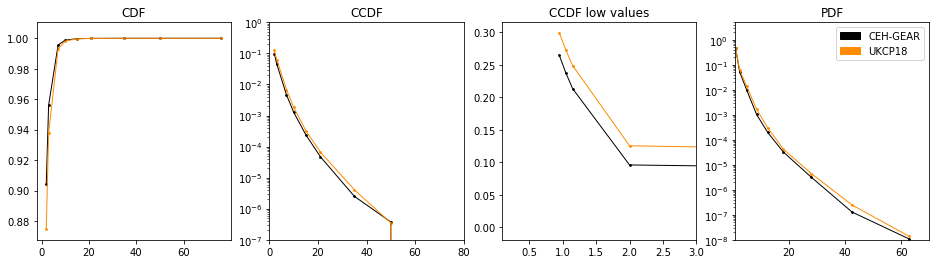

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(obs_overlap_bin_edges, obs_overlap_cdf ,linewidth = 1,s=3, color = 'black')
axs[0].plot(obs_overlap_bin_edges,obs_overlap_cdf ,linewidth = 1, color = 'black')
axs[0].scatter(model_overlap_bin_edges, model_overlap_cdf ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(model_overlap_bin_edges,model_overlap_cdf ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[1].scatter(obs_no_overlap_bin_edges, obs_no_overlap_ccdf ,linewidth = 1,s=3, color = 'black')
axs[1].plot(obs_no_overlap_bin_edges,obs_no_overlap_ccdf ,linewidth = 1, color = 'black')
axs[1].scatter(model_overlap_bin_edges, model_overlap_ccdf ,linewidth = 1,s=3, color = 'darkorange')
axs[1].plot(model_overlap_bin_edges,model_overlap_ccdf ,linewidth = 1, color = 'darkorange')
axs[1].set_yscale('log')
axs[1].set_xlim(0,80)
axs[1].set_ylim(1e-7,1)
axs[1].set_title('CCDF')

axs[2].scatter(obs_overlap_bin_edges_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
axs[2].plot(obs_overlap_bin_edges_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
axs[2].scatter(model_overlap_bin_edges_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'darkorange')
axs[2].plot(model_overlap_bin_edges_low,model_overlap_ccdf_low ,linewidth = 1, color = 'darkorange')
axs[2].set_xlim(0.1,3)
# axs[2].set_ylim(0.1,0.35)
axs[2].set_title('CCDF low values')

axs[3].scatter(obs_overlap_bin_centres_pdf, obs_overlap_pdf ,linewidth = 1,s=3, color = 'black')
axs[3].plot(obs_overlap_bin_centres_pdf,obs_overlap_pdf ,linewidth = 1, color = 'black')
axs[3].scatter(model_overlap_bin_centres_pdf, model_overlap_pdf ,linewidth = 1,s=3, color = 'darkorange')
axs[3].plot(model_overlap_bin_centres_pdf,model_overlap_pdf ,linewidth = 1, color = 'darkorange')
axs[3].set_title('PDF')
axs[3].set_yscale('log')
axs[3].set_xlim(0.95,70)
axs[3].set_ylim(1e-8,5)
axs[3].legend(handles=patches);

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(obs_overlap_bin_edges, obs_overlap_cdf ,linewidth = 1,s=3, color = 'black')
axs[0].plot(obs_overlap_bin_edges,obs_overlap_cdf ,linewidth = 1, color = 'black')
axs[0].scatter(model_overlap_bin_edges, model_overlap_cdf ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(model_overlap_bin_edges,model_overlap_cdf ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[1].scatter(obs_no_overlap_bin_edges, obs_no_overlap_ccdf ,linewidth = 1,s=3, color = 'black')
axs[1].plot(obs_no_overlap_bin_edges,obs_no_overlap_ccdf ,linewidth = 1, color = 'black')
axs[1].scatter(model_overlap_bin_edges, model_overlap_ccdf ,linewidth = 1,s=3, color = 'darkorange')
axs[1].plot(model_overlap_bin_edges,model_overlap_ccdf ,linewidth = 1, color = 'darkorange')
axs[1].set_yscale('log')
axs[1].set_xlim(0,80)
axs[1].set_ylim(1e-7,1)
axs[1].set_title('CCDF')

axs[2].scatter(obs_overlap_bin_edges_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
axs[2].plot(obs_overlap_bin_edges_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
axs[2].scatter(model_overlap_bin_edges_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'darkorange')
axs[2].plot(model_overlap_bin_edges_low,model_overlap_ccdf_low ,linewidth = 1, color = 'darkorange')
axs[2].set_xlim(0.1,3)
# axs[2].set_ylim(0.1,0.35)
axs[2].set_title('CCDF low values')

axs[3].scatter(obs_overlap_bin_centres_pdf, obs_overlap_pdf ,linewidth = 1,s=3, color = 'black')
axs[3].plot(obs_overlap_bin_centres_pdf,obs_overlap_pdf ,linewidth = 1, color = 'black')
axs[3].scatter(model_overlap_bin_centres_pdf, model_overlap_pdf ,linewidth = 1,s=3, color = 'darkorange')
axs[3].plot(model_overlap_bin_centres_pdf,model_overlap_pdf ,linewidth = 1, color = 'darkorange')
axs[3].set_title('PDF')
axs[3].set_yscale('log')
axs[3].set_xlim(0.95,70)
axs[3].set_ylim(1e-8,5)
axs[3].legend(handles=patches);

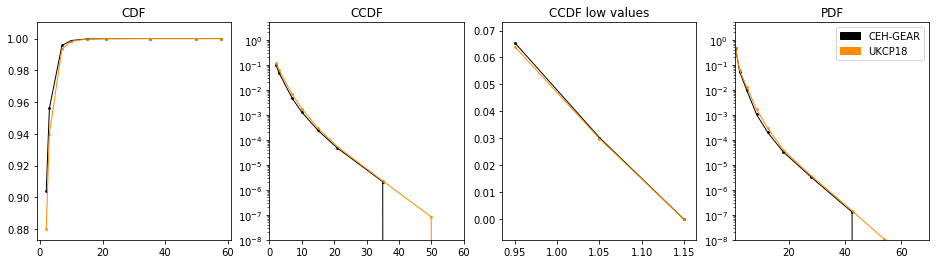

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(obs_overlap_bin_edges, obs_overlap_cdf ,linewidth = 1,s=3, color = 'black')
axs[0].plot(obs_overlap_bin_edges,obs_overlap_cdf ,linewidth = 1, color = 'black')
axs[0].scatter(model_overlap_bin_edges, model_overlap_cdf ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(model_overlap_bin_edges,model_overlap_cdf ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[1].scatter(obs_no_overlap_bin_edges, obs_no_overlap_ccdf ,linewidth = 1,s=3, color = 'black')
axs[1].plot(obs_no_overlap_bin_edges,obs_no_overlap_ccdf ,linewidth = 1, color = 'black')
axs[1].scatter(model_overlap_bin_edges, model_overlap_ccdf ,linewidth = 1,s=3, color = 'darkorange')
axs[1].plot(model_overlap_bin_edges,model_overlap_ccdf ,linewidth = 1, color = 'darkorange')
axs[1].set_yscale('log')
axs[1].set_xlim(0,60)
axs[1].set_ylim(1e-8,5)
axs[1].set_title('CCDF')

axs[2].scatter(obs_overlap_bin_edges_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
axs[2].plot(obs_overlap_bin_edges_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
axs[2].scatter(model_overlap_bin_edges_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'darkorange')
axs[2].plot(model_overlap_bin_edges_low,model_overlap_ccdf_low ,linewidth = 1, color = 'darkorange')
# axs[2].set_xlim(0.95,1.15)
# axs[2].set_ylim(0.225,0.35)
axs[2].set_title('CCDF low values')

axs[3].scatter(obs_overlap_bin_centres_pdf, obs_overlap_pdf ,linewidth = 1,s=3, color = 'black')
axs[3].plot(obs_overlap_bin_centres_pdf,obs_overlap_pdf ,linewidth = 1, color = 'black')
axs[3].scatter(model_overlap_bin_centres_pdf, model_overlap_pdf ,linewidth = 1,s=3, color = 'darkorange')
axs[3].plot(model_overlap_bin_centres_pdf,model_overlap_pdf ,linewidth = 1, color = 'darkorange')
axs[3].set_title('PDF')
axs[3].set_yscale('log')
axs[3].set_xlim(0.95,70)
axs[3].set_ylim(1e-8,5)
axs[3].legend(handles=patches);

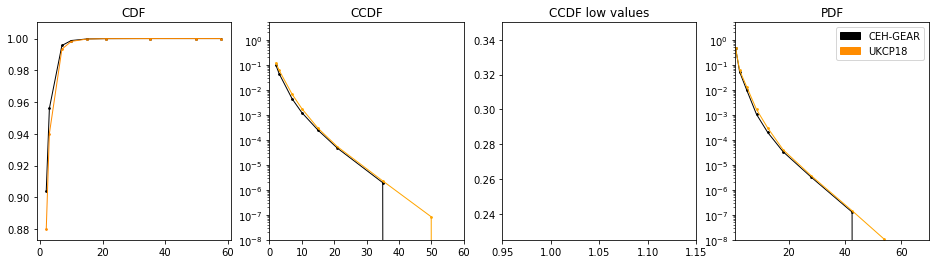

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(obs_overlap_bin_edges, obs_overlap_cdf ,linewidth = 1,s=3, color = 'black')
axs[0].plot(obs_overlap_bin_edges,obs_overlap_cdf ,linewidth = 1, color = 'black')
axs[0].scatter(model_overlap_bin_edges, model_overlap_cdf ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(model_overlap_bin_edges,model_overlap_cdf ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[1].scatter(obs_overlap_bin_edges, obs_overlap_ccdf ,linewidth = 1,s=3, color = 'black')
axs[1].plot(obs_overlap_bin_edges,obs_overlap_ccdf ,linewidth = 1, color = 'black')
axs[1].scatter(model_overlap_bin_edges, model_overlap_ccdf ,linewidth = 1,s=3, color = 'orange')
axs[1].plot(model_overlap_bin_edges,model_overlap_ccdf ,linewidth = 1, color = 'orange')
axs[1].set_yscale('log')
axs[1].set_xlim(0,60)
axs[1].set_ylim(1e-8,5)
axs[1].set_title('CCDF')

axs[2].scatter(obs_overlap_bin_edges_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
axs[2].plot(obs_overlap_bin_edges_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
axs[2].scatter(model_overlap_bin_edges_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
axs[2].plot(model_overlap_bin_edges_low,model_overlap_ccdf_low ,linewidth = 1, color = 'orange')
axs[2].set_xlim(0.95,1.15)
axs[2].set_ylim(0.225,0.35)
axs[2].set_title('CCDF low values')

axs[3].scatter(obs_overlap_bin_centres_pdf, obs_overlap_pdf ,linewidth = 1,s=3, color = 'black')
axs[3].plot(obs_overlap_bin_centres_pdf,obs_overlap_pdf ,linewidth = 1, color = 'black')
axs[3].scatter(model_overlap_bin_centres_pdf, model_overlap_pdf ,linewidth = 1,s=3, color = 'orange')
axs[3].plot(model_overlap_bin_centres_pdf,model_overlap_pdf ,linewidth = 1, color = 'orange')
axs[3].set_title('PDF')
axs[3].set_yscale('log')
axs[3].set_xlim(0.95,70)
axs[3].set_ylim(1e-8,5)
axs[3].legend(handles=patches);

### Old regridding method

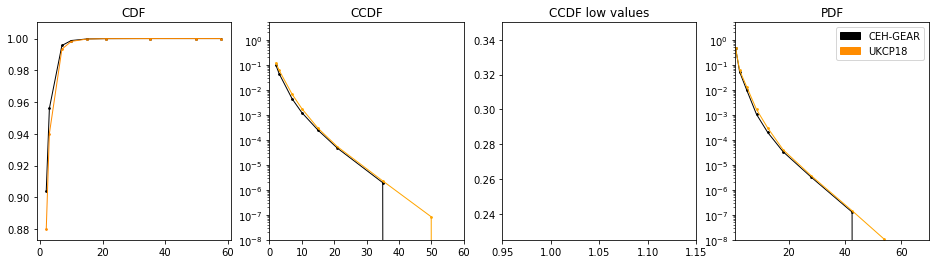

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(obs_overlap_bin_edges, obs_overlap_cdf ,linewidth = 1,s=3, color = 'black')
axs[0].plot(obs_overlap_bin_edges,obs_overlap_cdf ,linewidth = 1, color = 'black')
axs[0].scatter(model_overlap_bin_edges, model_overlap_cdf ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(model_overlap_bin_edges,model_overlap_cdf ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[1].scatter(obs_overlap_bin_edges, obs_overlap_ccdf ,linewidth = 1,s=3, color = 'black')
axs[1].plot(obs_overlap_bin_edges,obs_overlap_ccdf ,linewidth = 1, color = 'black')
axs[1].scatter(model_overlap_bin_edges, model_overlap_ccdf ,linewidth = 1,s=3, color = 'orange')
axs[1].plot(model_overlap_bin_edges,model_overlap_ccdf ,linewidth = 1, color = 'orange')
axs[1].set_yscale('log')
axs[1].set_xlim(0,60)
axs[1].set_ylim(1e-8,5)
axs[1].set_title('CCDF')

axs[2].scatter(obs_overlap_bin_edges_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
axs[2].plot(obs_overlap_bin_edges_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
axs[2].scatter(model_overlap_bin_edges_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
axs[2].plot(model_overlap_bin_edges_low,model_overlap_ccdf_low ,linewidth = 1, color = 'orange')
axs[2].set_xlim(0.95,1.15)
axs[2].set_ylim(0.225,0.35)
axs[2].set_title('CCDF low values')

axs[3].scatter(obs_overlap_bin_centres_pdf, obs_overlap_pdf ,linewidth = 1,s=3, color = 'black')
axs[3].plot(obs_overlap_bin_centres_pdf,obs_overlap_pdf ,linewidth = 1, color = 'black')
axs[3].scatter(model_overlap_bin_centres_pdf, model_overlap_pdf ,linewidth = 1,s=3, color = 'orange')
axs[3].plot(model_overlap_bin_centres_pdf,model_overlap_pdf ,linewidth = 1, color = 'orange')
axs[3].set_title('PDF')
axs[3].set_yscale('log')
axs[3].set_xlim(0.95,70)
axs[3].set_ylim(1e-8,5)
axs[3].legend(handles=patches);

### Not overlapping data

Text(0.5,1,'CCDF low values')

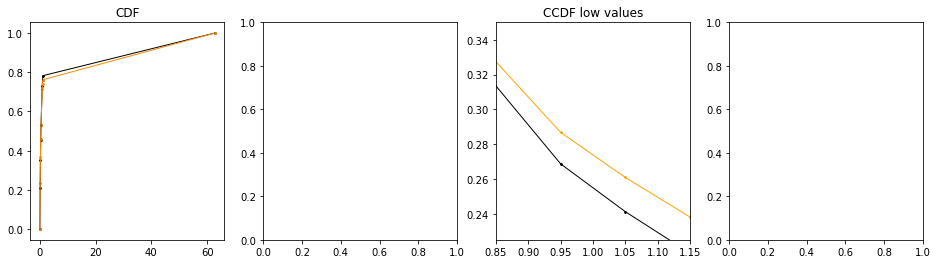

In [18]:
low_bins_i_want = [0.05,0.1, 0.2, 0.3, 0.4, 0.5, 0.95, 1.05, 1.15, np.nanmax(obs_data_overlap)]

obs_no_overlap_cdf_low, obs_no_overlap_ccdf_low, obs_no_overlap_bin_centres_low,  obs_no_overlap_bin_edges_low  = calculate_ccdf_wetvalues(obs_data_no_overlap, low_bins_i_want)
model_no_overlap_cdf_low, model_no_overlap_ccdf_low, model_no_overlap_bin_centres_low, model_no_overlap_bin_edges_low = calculate_ccdf_wetvalues(model_data_no_overlap,low_bins_i_want)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(obs_no_overlap_bin_edges_low, obs_no_overlap_cdf_low ,linewidth = 1,s=3, color = 'black')
axs[0].plot(obs_no_overlap_bin_edges_low,obs_no_overlap_cdf_low ,linewidth = 1, color = 'black')
axs[0].scatter(model_no_overlap_bin_edges_low, model_no_overlap_cdf_low ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(model_no_overlap_bin_edges_low,model_no_overlap_cdf_low ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[2].scatter(obs_no_overlap_bin_edges_low, obs_no_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
axs[2].plot(obs_no_overlap_bin_edges_low,obs_no_overlap_ccdf_low ,linewidth = 1, color = 'black')
axs[2].scatter(model_no_overlap_bin_edges_low, model_no_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
axs[2].plot(model_no_overlap_bin_edges_low,model_no_overlap_ccdf_low ,linewidth = 1, color = 'orange')
axs[2].set_xlim(0.85,1.15)
axs[2].set_ylim(0.225,0.35)
axs[2].set_title('CCDF low values')

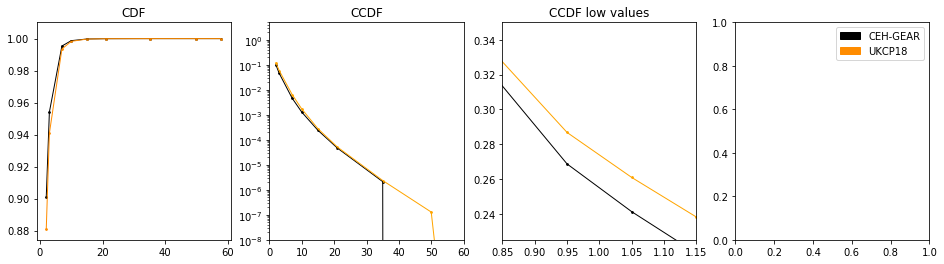

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(obs_no_overlap_bin_edges, obs_no_overlap_cdf ,linewidth = 1,s=3, color = 'black')
axs[0].plot(obs_no_overlap_bin_edges,obs_no_overlap_cdf ,linewidth = 1, color = 'black')
axs[0].scatter(model_no_overlap_bin_edges, model_no_overlap_cdf ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(model_no_overlap_bin_edges,model_no_overlap_cdf ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[1].scatter(obs_no_overlap_bin_edges, obs_no_overlap_ccdf ,linewidth = 1,s=3, color = 'black')
axs[1].plot(obs_no_overlap_bin_edges,obs_no_overlap_ccdf ,linewidth = 1, color = 'black')
axs[1].scatter(model_no_overlap_bin_edges, model_no_overlap_ccdf ,linewidth = 1,s=3, color = 'orange')
axs[1].plot(model_no_overlap_bin_edges,model_no_overlap_ccdf ,linewidth = 1, color = 'orange')
axs[1].set_yscale('log')
axs[1].set_xlim(0,60)
axs[1].set_ylim(1e-8,5)
axs[1].set_title('CCDF')

axs[2].scatter(obs_no_overlap_bin_edges_low, obs_no_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
axs[2].plot(obs_no_overlap_bin_edges_low,obs_no_overlap_ccdf_low ,linewidth = 1, color = 'black')
axs[2].scatter(model_no_overlap_bin_edges_low, model_no_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
axs[2].plot(model_no_overlap_bin_edges_low,model_no_overlap_ccdf_low ,linewidth = 1, color = 'orange')
axs[2].set_xlim(0.85,1.15)
axs[2].set_ylim(0.225,0.35)
axs[2].set_title('CCDF low values')

# axs[3].scatter(obs_no_overlap_bin_centres_pdf, obs_no_overlap_pdf ,linewidth = 1,s=3, color = 'black')
# axs[3].plot(obs_no_overlap_bin_centres_pdf,obs_no_overlap_pdf ,linewidth = 1, color = 'black')
# axs[3].scatter(model_ono_verlap_bin_centres_pdf, model_no_overlap_pdf ,linewidth = 1,s=3, color = 'orange')
# axs[3].plot(model_no_overlap_bin_centres_pdf,model_no_overlap_pdf ,linewidth = 1, color = 'orange')
# axs[3].set_title('PDF')
# axs[3].set_yscale('log')
# axs[3].set_xlim(0.95,70)
# axs[3].set_ylim(1e-8,5)
axs[3].legend(handles=patches);

### Plot for each ensemble member separately

In [20]:
# ems = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']

# fig, axs = plt.subplots(nrows=12, ncols=4, figsize=(16,30))
# for ax_num, em in enumerate(ems):
#     model_data_overlap = np.array([])
#     model_data_no_overlap = np.array([])
    
#     print(em)
#     datadir = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_hourly/2.2km_regridded_12km/1980_2001/{em}/'
#     for yr in range(1981,2001):
#         file_name = datadir + f"compressed_{yr}.npy"
#         this_yr = np.load(file_name)
#         model_data_no_overlap =np.append(model_data_no_overlap, this_yr)
#         if yr >=1990 and yr <=2001:
#             model_data_overlap =np.append(model_data_overlap, this_yr)
#     # bins_i_want =  [0.1, 0.5,2, 3, 7, 10,15, 21, 35,45, 62, 78]
#     obs_overlap_cdf, obs_overlap_ccdf, obs_overlap_bin_centres = calculate_ccdf_wetvalues(obs_data_overlap, bins_i_want)
#     model_overlap_cdf, model_overlap_ccdf, model_overlap_bin_centres = calculate_ccdf_wetvalues(model_data_overlap,bins_i_want)
    
#     axs[ax_num, 0].scatter(obs_overlap_bin_centres, obs_overlap_cdf ,linewidth = 1,s=3, color = 'black')
#     axs[ax_num, 0].plot(obs_overlap_bin_centres,obs_overlap_cdf ,linewidth = 1, color = 'black')
#     axs[ax_num, 0].scatter(model_overlap_bin_centres, model_overlap_cdf ,linewidth = 1,s=3, color = 'darkorange')
#     axs[ax_num, 0].plot(model_overlap_bin_centres,model_overlap_cdf ,linewidth = 1, color = 'darkorange')
#     axs[ax_num, 0].set_title('CDF')

#     axs[ax_num, 1].scatter(obs_overlap_bin_centres, obs_overlap_ccdf ,linewidth = 1,s=3, color = 'black')
#     axs[ax_num, 1].plot(obs_overlap_bin_centres,obs_overlap_ccdf ,linewidth = 1, color = 'black')
#     axs[ax_num, 1].scatter(model_overlap_bin_centres, model_overlap_ccdf ,linewidth = 1,s=3, color = 'orange')
#     axs[ax_num, 1].plot(model_overlap_bin_centres,model_overlap_ccdf ,linewidth = 1, color = 'orange')
#     axs[ax_num, 1].set_yscale('log')
#     axs[ax_num, 1].set_ylim(1e-8,5)
#     axs[ax_num, 1].set_title('CCDF')

#     axs[ax_num, 2].scatter(obs_overlap_bin_centres_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
#     axs[ax_num, 2].plot(obs_overlap_bin_centres_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
#     axs[ax_num, 2].scatter(model_overlap_bin_centres_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
#     axs[ax_num, 2].plot(model_overlap_bin_centres_low,model_overlap_ccdf_low ,linewidth = 1, color = 'orange')
#     axs[ax_num, 2].set_title('CCDF low values')

#     axs[ax_num, 3].scatter(obs_overlap_bin_centres_pdf, obs_overlap_pdf ,linewidth = 1,s=3, color = 'black')
#     axs[ax_num, 3].plot(obs_overlap_bin_centres_pdf,obs_overlap_pdf ,linewidth = 1, color = 'black')
#     axs[ax_num, 3].scatter(model_overlap_bin_centres_pdf, model_overlap_pdf ,linewidth = 1,s=3, color = 'orange')
#     axs[ax_num, 3].plot(model_overlap_bin_centres_pdf,model_overlap_pdf ,linewidth = 1, color = 'orange')
#     axs[ax_num, 3].set_title('PDF')
#     axs[ax_num, 3].set_yscale('log')
#     axs[ax_num, 3].set_ylim(1e-8,5)
#     axs[ax_num, 3].legend(handles=patches);
